# End-to-End Agent: Real-Time Stock Price Analysis

This notebook demonstrates a **complete agentic workflow** using LangGraph:
1. Fetch **live financial data** from the **Alpha Vantage API** (instead of demo prices).
2. Use multiple tools (real-time price, company overview, earnings, etc.).
3. Integrate reasoning to answer complex stock-related questions.

**Automatic Tracing:**
LangSmith tracing works automatically if `LANGCHAIN_API_KEY` and related environment variables are set, even without explicit tracers.

At the end, a public LangSmith trace link is provided as an example.


In [1]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [4]:
class State(TypedDict):
    """
    Conversation state schema:
    - messages: list of {"role", "content"} chat messages
    """
    messages: Annotated[list, add_messages]

In [5]:
# ── Common helper function for Alpha Vantage API calls ───────────────────────
def alpha_vantage_call(params: dict) -> dict:
    """
    Makes a request to the Alpha Vantage API with the given parameters.

    This function automatically:
      - Reads the base URL and API key from environment variables.
      - Adds the API key to the request parameters.
      - Sends a GET request and returns the JSON response.

    Environment Variables Required:
      - ALPHA_VANTAGE_BASE_URL
      - ALPHA_VANTAGE_API_KEY

    Args:
        params (dict): Parameters for the Alpha Vantage API call.

    Returns:
        dict: Parsed JSON response from the API.

    Raises:
        HTTPError: If the API request fails (non-200 status code).
    """
    base_url = os.getenv("ALPHA_VANTAGE_BASE_URL")
    api_key = os.getenv("ALPHA_VANTAGE_API_KEY")

    params["apikey"] = api_key
    response = requests.get(base_url, params=params)
    response.raise_for_status()
    return response.json()


# ── Define tools for each functionality ─────────────────────────────────────

@tool
def get_realtime_stock(symbol: str) -> str:
    """
    Fetches the latest available intraday stock price for the given symbol.

    API Reference:
        https://www.alphavantage.co/documentation/#intraday

    Args:
        symbol (str): Stock ticker symbol (e.g., "AAPL", "MSFT").

    Returns:
        str: Latest stock price in USD, formatted to 2 decimal places.
             Returns an error message if no data is available.
    """
    data = alpha_vantage_call({
        "function": "TIME_SERIES_INTRADAY",
        "symbol": symbol.upper(),
        "interval": "5min"
    })
    time_series = data.get("Time Series (5min)")
    if not time_series:
        return f"Error: Could not fetch real-time data for {symbol}."
    latest_timestamp = max(time_series.keys())
    latest_data = time_series[latest_timestamp]
    return f"The latest price for {symbol.upper()} is ${float(latest_data['1. open']):.2f}."


@tool
def search_ticker(company_name: str) -> str:
    """
    Searches for ticker symbols that match the given company name.

    API Reference:
        https://www.alphavantage.co/documentation/#symbolsearch

    Args:
        company_name (str): Partial or full name of the company.

    Returns:
        str: List of matching ticker symbols with company name and region.
             Returns a message if no results are found.
    """
    data = alpha_vantage_call({
        "function": "SYMBOL_SEARCH",
        "keywords": company_name
    })
    best_matches = data.get("bestMatches", [])
    if not best_matches:
        return f"No ticker symbols found for {company_name}."
    results = [f"{match['1. symbol']} - {match['2. name']} ({match['4. region']})"
               for match in best_matches]
    return f"Search results for '{company_name}':\n" + "\n".join(results)


@tool
def get_company_overview(symbol: str) -> str:
    """
    Retrieves a company's overview and key financial metrics.

    API Reference:
        https://www.alphavantage.co/documentation/#company-overview

    Args:
        symbol (str): Stock ticker symbol.

    Returns:
        str: Overview including sector, industry, market cap, revenue, EPS, and P/E ratio.
             Returns a message if no data is found.
    """
    data = alpha_vantage_call({
        "function": "OVERVIEW",
        "symbol": symbol.upper(),
    })
    if not data:
        return f"No company overview found for {symbol}."
    return (f"Company Overview for {symbol.upper()}:\n"
            f"Name: {data.get('Name')}\nSector: {data.get('Sector')}\nIndustry: {data.get('Industry')}\n"
            f"Market Cap: {data.get('MarketCapitalization')}\nRevenue: {data.get('RevenueTTM')}\n"
            f"EPS: {data.get('EPS')}\nPE Ratio: {data.get('PERatio')}")


@tool
def get_earnings_data(symbol: str) -> str:
    """
    Fetches the most recent quarterly earnings report for the given symbol.

    API Reference:
        https://www.alphavantage.co/documentation/#earnings

    Args:
        symbol (str): Stock ticker symbol.

    Returns:
        str: Latest quarterly earnings data (fiscal date, reported EPS, estimated EPS).
             Returns a message if no earnings data is found.
    """
    data = alpha_vantage_call({
        "function": "EARNINGS",
        "symbol": symbol.upper(),
    })
    if not data:
        return f"No earnings data found for {symbol}."
    quarterly_data = data.get("quarterlyEarnings", [])
    if not quarterly_data:
        return f"No recent earnings data available for {symbol}."
    latest_earnings = quarterly_data[0]
    return (f"Earnings Data for {symbol.upper()}:\nFiscal Date Ending: {latest_earnings['fiscalDateEnding']}\n"
            f"Reported EPS: {latest_earnings['reportedEPS']}\nEstimated EPS: {latest_earnings.get('estimatedEPS', 'N/A')}.")


@tool
def get_historical_stock_data(symbol: str, interval: str = "daily") -> str:
    """
    Fetches and summarizes historical stock price data for the given symbol and interval.

    Only summary metrics are returned (latest date, open/close price, highest/lowest price,
    total trading volume).

    API Reference:
        https://www.alphavantage.co/documentation/

    Args:
        symbol (str): Stock ticker symbol.
        interval (str): Time interval for historical data. Options:
                        "daily" (default), "weekly", "monthly".

    Returns:
        str: Summary of historical stock performance.
             Returns an error message if data is unavailable.
    """
    try:
        function_mapping = {
            "daily": "TIME_SERIES_DAILY",
            "weekly": "TIME_SERIES_WEEKLY",
            "monthly": "TIME_SERIES_MONTHLY",
        }
        function = function_mapping.get(interval.lower(), "TIME_SERIES_DAILY")

        # Request data from Alpha Vantage
        data = alpha_vantage_call({
            "function": function,
            "symbol": symbol.upper(),
        })

        # Extract the relevant time series
        time_series_key = next(iter(data))  # First key in the response contains the time series
        time_series = data.get(time_series_key)

        if not time_series:
            return f"Failed to fetch {interval.title()} data for {symbol.upper()}."

        # Calculate summary metrics
        latest_date = max(time_series.keys())
        latest_data = time_series[latest_date]

        highest_price = max(float(info["2. high"]) for info in time_series.values())
        lowest_price = min(float(info["3. low"]) for info in time_series.values())
        total_volume = sum(int(info.get("5. volume", 0)) for info in time_series.values())

        return (f"Summary of {symbol.upper()} stock ({interval.title()} data):\n"
                f"- Latest Date: {latest_date}\n"
                f"- Open Price: ${float(latest_data['1. open']):.2f}\n"
                f"- Close Price: ${float(latest_data['4. close']):.2f}\n"
                f"- Highest Price: ${highest_price:.2f}\n"
                f"- Lowest Price: ${lowest_price:.2f}\n"
                f"- Total Volume: {total_volume:,} shares")

    except Exception as e:
        return f"An error occurred while fetching data for {symbol.upper()}: {str(e)}"

# Initialize LLM and bind tools
tools = [get_realtime_stock, search_ticker, get_company_overview, get_earnings_data, get_historical_stock_data]

llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

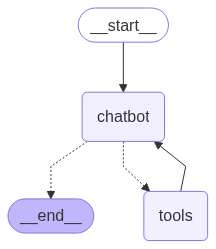

In [6]:

def chatbot(state: State):
    """
    LLM node: takes user messages, calls tools if required, and reasons over results.
    """
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot")
builder.add_edge("chatbot", END)

# Compile graph with memory enabled (tracing auto-enabled via environment vars)
graph = builder.compile(checkpointer=memory)

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Test the End-to-End Agent

Ask complex questions combining multiple tools, e.g.:
- “What’s the current price of AMZN?”
- “Give me the latest earnings data for MSFT.”
- “Search for Apple’s ticker and give me its company overview.”

The agent uses reasoning and real-time data fetching from Alpha Vantage.


In [7]:
# Example Invocation
config = {"configurable": {"thread_id": "finance_chat"}}
state = None
while True:
    user_input = input("You: ").strip()
    print("Human:", user_input)
    if user_input.lower() in {"quit", "exit"}:
        break

    if not state:
        state = {"messages": [{"role": "user", "content": user_input}]}
    else:
        state["messages"].append({"role": "user", "content": user_input})

    state = graph.invoke(state, config=config)
    print("Bot:", state["messages"][-1].content)

Human: Amazon Overview
Bot: Okay, here's the overview for Amazon (AMZN):

*   **Name:** Amazon.com Inc
*   **Sector:** TRADE & SERVICES
*   **Industry:** RETAIL-CATALOG & MAIL-ORDER HOUSES
*   **Market Cap:** 2379659084000
*   **Revenue:** 670038032000
*   **EPS:** 6.58
*   **PE Ratio:** 33.91
Human: exit


## 📊 Example LangSmith Trace — Multi-Tool Financial Data Retrieval

This complete agent uses **memory (`MemorySaver`)** to maintain per-thread state, enabling multi-turn conversations and reasoning across queries.
LangSmith tracing is automatically enabled when the following environment variables are set:

- `LANGCHAIN_API_KEY` – your LangSmith API key
- `LANGCHAIN_PROJECT` – project name where traces will be logged
- *(Optional)* `LANGCHAIN_ENDPOINT` – custom endpoint (otherwise default is used)

---

### **About the Trace**

Below is an example run captured from **LangSmith**, showing how the agent autonomously breaks down a user request, calls multiple Alpha Vantage tools, and combines the results into a final answer.

This trace demonstrates:
- **Automatic tool selection** based on LLM reasoning
- **Chained tool calls** (`search_ticker` → `get_company_overview`)
- **Memory support** so the agent can reuse intermediate results
- **End-to-end execution** from natural language input to structured output

---

### **Trace Overview**
> **Note:** GitHub’s notebook preview strips most custom HTML/CSS, so the screenshots below may appear **stacked vertically** here.
> For the intended **side-by-side** layout, open this notebook locally in **Jupyter** or **VS Code**.
<div style="display:grid; grid-template-columns: 1fr 1fr; gap: 14px; user-select:none; -webkit-user-select:none; -moz-user-select:none; -ms-user-select:none;">

  <!-- Row 1: Full-width overview -->
  <figure style="grid-column: 1 / -1; margin:0;">
    <img src="docs/9_full_trace_flow.png"
         alt="Full Trace Flow"
         style="width:100%; border-radius:8px; display:block; pointer-events:none; -webkit-user-drag:none;" />
    <figcaption style="margin-top:6px; font-weight:600;">1️⃣ Full Trace Flow</figcaption>
  </figure>

  <!-- Row 2: two side-by-side -->
  <figure style="margin:0;">
    <img src="docs/9_initial_llm_reasoning.png"
         alt="Initial LLM Reasoning & Tool List"
         style="width:100%; border-radius:8px; display:block; pointer-events:none; -webkit-user-drag:none;" />
    <figcaption style="margin-top:6px; font-weight:600;">2️⃣ Initial LLM Reasoning & Tool List</figcaption>
  </figure>

  <figure style="margin:0;">
    <img src="docs/9_ticker_tool_call.png"
         alt="search_ticker Tool Call & Output"
         style="width:100%; border-radius:8px; display:block; pointer-events:none; -webkit-user-drag:none;" />
    <figcaption style="margin-top:6px; font-weight:600;">3️⃣ <code>search_ticker</code> Tool Call & Output</figcaption>
  </figure>

  <!-- Row 3: two side-by-side -->
  <figure style="margin:0;">
    <img src="docs/9_next_tool_selection_llm.png"
         alt="LLM Selecting Next Tool"
         style="width:100%; border-radius:8px; display:block; pointer-events:none; -webkit-user-drag:none;" />
    <figcaption style="margin-top:6px; font-weight:600;">4️⃣ LLM Selecting Next Tool</figcaption>
  </figure>

  <figure style="margin:0;">
    <img src="docs/9_overview_tool_call.png"
         alt="get_company_overview Tool Call & Output"
         style="width:100%; border-radius:8px; display:block; pointer-events:none; -webkit-user-drag:none;" />
    <figcaption style="margin-top:6px; font-weight:600;">5️⃣ <code>get_company_overview</code> Tool Call & Output</figcaption>
  </figure>

</div>
